## Exercise - DL Tutorial 07

### student names:

Submit you solution by 01 June to manuel.milling@informatik.uni-augsburg.de AND maurice.gerczuk@informatik.uni-augsburg.de

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from os.path import basename
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, BatchNormalization, Dense, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [2]:
#train_speakers = ["03", "08", "09", "10", "11", "12", "13"]
train_speakers = ["03", "08", "09", "10", "11"]
validation_speakers = ["12", "13"]
test_speakers = ["14", "15", "16"]
data_path = "emodb/wav/"
label_dict = {"A" : 0, "F": 1, "L": 2, "N": 3, "T": 4, "W": 5, "E": 6}
num_classes = len(label_dict.keys())
cutoff_length = 4 #s

2. Prepare data and labels by cutting/zero-padding to 4 seconds, extracting spectrograms. 

In [3]:
files = glob(data_path + "*.wav")
files.sort()

len(files), files[0]

(535, 'emodb/wav/03a01Fa.wav')

In [4]:
files = glob(data_path + "*.wav")
files.sort()

x_train = []
y_train = []

x_test = []
y_test = []

x_validation = []
y_validation = []

for f in files:
    signal, sr = librosa.load(f)
    max_len = sr * 4
    if len(signal) > max_len:
        signal = signal[:max_len]
    elif len(signal < max_len):
        zeros = np.zeros(max_len - len(signal))
        signal = np.append(signal, zeros)

    spec = librosa.feature.melspectrogram(y=signal, n_fft = 4096, sr=44100)
    spec = librosa.power_to_db(spec)

    name = f[-11:]
    tag = name[0:2]
    feeling = name[5]

    if tag in train_speakers:
        x_train.append(spec)
        y_train.append(label_dict[feeling])
    elif tag in validation_speakers:
        x_validation.append(spec)
        y_validation.append(label_dict[feeling])
    elif tag in test_speakers:
        x_test.append(spec)
        y_test.append(label_dict[feeling])

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
y_test = tf.keras.utils.to_categorical(y_test)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
y_train = tf.keras.utils.to_categorical(y_train)

x_validation = np.asarray(x_validation)
y_validation = np.asarray(y_validation)
y_validation = tf.keras.utils.to_categorical(y_validation)

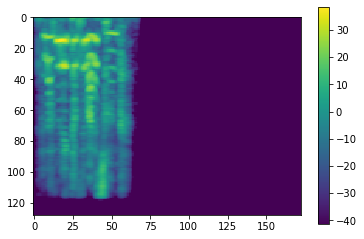

In [5]:
plt.imshow(x_test[0])
plt.colorbar()
plt.show()

In [6]:
print("x_train shape:\t\t{}".format(x_train.shape))
print("x_validation shape:\t{}".format(x_validation.shape))
print("x_test shape:\t\t{}".format(x_test.shape))
print("y_train shape:\t\t{}".format(y_train.shape))
print("y_validation shape:\t{}".format(y_validation.shape))
print("y_test shape:\t\t{}".format(y_test.shape))

x_train shape:		(243, 128, 173)
x_validation shape:	(96, 128, 173)
x_test shape:		(196, 128, 173)
y_train shape:		(243, 7)
y_validation shape:	(96, 7)
y_test shape:		(196, 7)


#### Reshaping data to receive 4 dimensions 
#### [None, height, width, channel]

In [7]:
x_train_reshaped = x_train.reshape(list(x_train.shape) + [1]) 
x_train_reshaped.shape

(243, 128, 173, 1)

In [10]:
x_validation_reshaped = x_validation.reshape(list(x_validation.shape) + [1]) 
x_validation_reshaped.shape

(96, 128, 173, 1)

In [22]:
x_test_reshape = x_test.reshape(list(x_test.shape) + [1]) 
x_test_reshape.shape

(196, 128, 173, 1)

3. Implement CNN-based model

In [24]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = Sequential([
    Conv2D(filters = 8, kernel_size = 3, strides=1, activation="relu", padding="valid", 
                           input_shape=x_train_reshaped.shape[1:]),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2, strides = 2),
    Conv2D(16, 3, strides = 1, activation="relu"),
    MaxPooling2D(pool_size = 2, strides = 2),
    Flatten(),
    Dense(7, activation="softmax")
])

model.compile(optimizer = Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 171, 8)       80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 126, 171, 8)       32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 85, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 83, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 41, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19680)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

4. Train model with early stopping. Evaluate on test data and plot the training history.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)


history = model.fit(x_train_reshaped, y_train, epochs=30, batch_size=16, 
                    validation_data=(x_validation_reshaped, y_validation),
                   callbacks=[early_stopping_cb])

Epoch 1/30
16/16 [==============================] - 2s 92ms/step - loss: 5.2993 - accuracy: 0.2716 - val_loss: 4.0279 - val_accuracy: 0.2292
Epoch 2/30
16/16 [==============================] - 1s 84ms/step - loss: 0.9689 - accuracy: 0.6461 - val_loss: 1.7081 - val_accuracy: 0.4271
Epoch 3/30
16/16 [==============================] - 1s 85ms/step - loss: 0.4687 - accuracy: 0.8436 - val_loss: 1.4331 - val_accuracy: 0.5312
Epoch 4/30
16/16 [==============================] - 1s 86ms/step - loss: 0.2333 - accuracy: 0.9300 - val_loss: 1.8142 - val_accuracy: 0.5312
Epoch 5/30
16/16 [==============================] - 1s 87ms/step - loss: 0.1062 - accuracy: 0.9877 - val_loss: 1.3365 - val_accuracy: 0.5729
Epoch 6/30
16/16 [==============================] - 1s 87ms/step - loss: 0.0596 - accuracy: 0.9959 - val_loss: 1.2185 - val_accuracy: 0.6354
Epoch 7/30
16/16 [==============================] - 1s 87ms/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 1.2788 - val_accuracy: 0.6146
Epoch 8/30
16

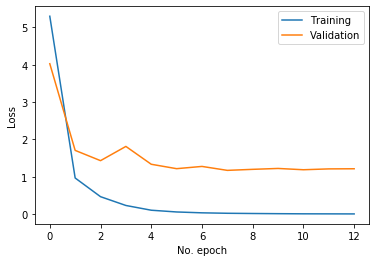

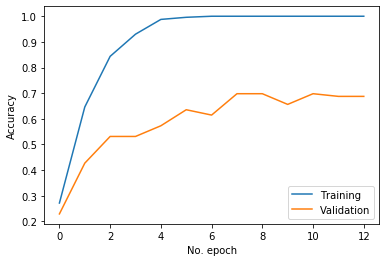

In [29]:
p = plt.figure(1)
plt.plot(history.history['loss'], label="Training")
plt.plot(history.history['val_loss'], label="Validation")
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")

p2 = plt.figure(2)
plt.plot(history.history['accuracy'], label="Training")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")

plt.show()

#### Model overfits badly

In [30]:
model.evaluate(x_test_reshape, y_test)

7/7 [==============================] - 0s 31ms/step - loss: 2.0961 - accuracy: 0.5255


[2.096146821975708, 0.5255101919174194]